In [1]:
import pandas_datareader as web
from datetime import date
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
def get_dates(data_window):
    '''
    Returns the start date and end date for given number of years

    Parameters:
    data_window (int): number of years of past data

    Returns:
    start_date (datetime): start date
    end_date (datetime): today's date
    '''
    end_date = pd.to_datetime(date.today())
    start_date = pd.to_datetime(
        date.today() + relativedelta(years=-data_window))

    return start_date, end_date

In [3]:
# take a look at stock
data_window = 1  # number of years of historical data to look at
start_date, end_date = get_dates(data_window)
stock = 'SPY'  # stock symbol

df = web.DataReader(stock, data_source='yahoo',
                    start=start_date, end=end_date)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-13,271.480011,248.520004,263.089996,269.320007,329566100.0,264.382690
2020-03-16,256.899994,237.360001,241.179993,239.850006,297240000.0,235.452972
2020-03-17,256.170013,237.070007,245.039993,252.800003,262070500.0,248.165558
2020-03-18,248.369995,228.020004,236.250000,240.000000,327597100.0,235.600204
2020-03-19,247.380005,232.220001,239.250000,240.509995,289322000.0,236.100845
...,...,...,...,...,...,...
2021-03-08,387.679993,381.420013,384.660004,381.720001,122957100.0,381.720001
2021-03-09,389.910004,385.309998,385.850006,387.170013,113457800.0,387.170013
2021-03-10,391.399994,388.170013,389.690002,389.579987,109660800.0,389.579987


In [4]:
# check for null values
df.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

Text(0.5, 1.0, 'SPY')

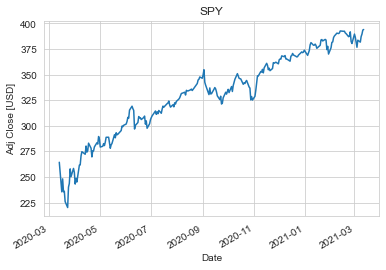

In [5]:
# plot adjusted close
sns.set_style('whitegrid')
df['Adj Close'].plot()
plt.xlabel('Date')
plt.ylabel('Adj Close [USD]')
plt.title(stock)

In [6]:
future_days = 28  # number of days lookahead for future value
# future value is adjusted close future_days into the future
df['Future'] = df['Adj Close'].shift(-future_days)

In [7]:
# take a look at the dataframe now
df

,High,Low,Open,Close,Volume,Adj Close,Future
Date,,,,,,,
2020-03-13,271.480011,248.520004,263.089996,269.320007,329566100.0,264.382690,275.574738
2020-03-16,256.899994,237.360001,241.179993,239.850006,297240000.0,235.452972,279.415924
2020-03-17,256.170013,237.070007,245.039993,252.800003,262070500.0,248.165558,283.444672
2020-03-18,248.369995,228.020004,236.250000,240.000000,327597100.0,235.600204,282.141235
2020-03-19,247.380005,232.220001,239.250000,240.509995,289322000.0,236.100845,289.527283
...,...,...,...,...,...,...,...
2021-03-08,387.679993,381.420013,384.660004,381.720001,122957100.0,381.720001,NaN
2021-03-09,389.910004,385.309998,385.850006,387.170013,113457800.0,387.170013,NaN
2021-03-10,391.399994,388.170013,389.690002,389.579987,109660800.0,389.579987,NaN


In [8]:
# define features and labels
X = df.drop('Future', axis=1).iloc[:-future_days]
y = df['Future'].iloc[:-future_days]

In [9]:
# split data into train and test sets
X_train = X.iloc[:-future_days]
y_train = y.iloc[:-future_days]
X_test = X.iloc[-future_days:]
y_test = y.iloc[-future_days:]

In [10]:
def plot_prediction(model):
    '''
    Plots actual and predicted stock price using a given machine learning model. 
    Provides evaluation metrics as well.

    Parameters:
    model: machine learning model

    Returns:
    None
    '''

    model.fit(X_train, y_train)  # train model
    y_pred = model.predict(X_test)  # make predictions on test dataset
    # store the adjusted close results in a dataframe
    results = pd.DataFrame(
        {'Actual': df['Adj Close'].iloc[-future_days:], 'Predicted': y_pred})

    # print evaluation metrics
    print('Mean Absolute Error:', metrics.mean_absolute_error(results['Actual'], results['Predicted']))
    print('Mean Squared Error:', metrics.mean_squared_error(results['Actual'], results['Predicted']))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(results['Actual'], results['Predicted'])))

    # plot data
    plt.figure(figsize=(14, 6))

    plt.subplot(1,2,1) # subplot 1
    df['Adj Close'].plot(label='Actual')
    results['Predicted'].plot(label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Adj Close [USD]')
    plt.title(stock)

    plt.subplot(1,2,2) # subplot 2 zoomed in
    df['Adj Close'].iloc[-y_test.shape[0]:].plot(label='Actual')
    results['Predicted'].plot(label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Adj Close [USD]')
    plt.title(stock + ' (closer look at test data)')

### Use decision tree

Mean Absolute Error: 14.813921247209821
Mean Squared Error: 258.488316480536
Root Mean Squared Error: 16.07757184653628


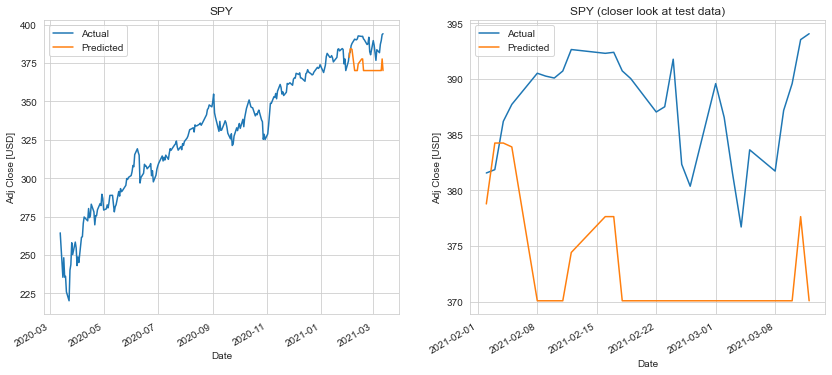

In [11]:
plot_prediction(DecisionTreeRegressor())

### Use linear regression

Mean Absolute Error: 6.709653388136799
Mean Squared Error: 81.00075650354223
Root Mean Squared Error: 9.000042027876438


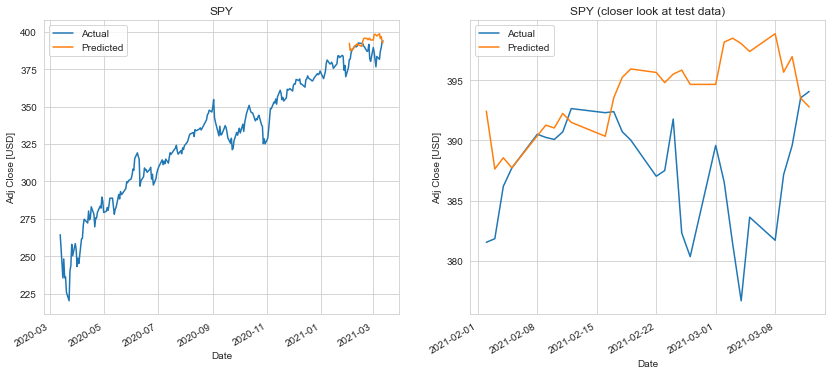

In [12]:
plot_prediction(LinearRegression())